In [30]:
import numpy as np # linear algebra 
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import os
#for dirname, _, filenames in os.walk('/kaggle/input'):
    #for filename in filenames:
       # print(os.path.join(dirname, filename))
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
import keras
from keras.preprocessing import image
from keras.models import Sequential
from keras.layers import Conv2D, MaxPool2D, Flatten,Dense,Dropout,BatchNormalization
from tensorflow.keras.models import Model
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import cv2
from tensorflow.keras.applications import VGG16
from tensorflow.keras.callbacks import ReduceLROnPlateau, ModelCheckpoint, EarlyStopping
from keras import regularizers
from tensorflow.keras.optimizers import Adam,RMSprop,SGD,Adamax
from sklearn.metrics import classification_report
from tensorflow.keras.models import load_model


In [31]:
train_dir = "/kaggle/input/fer2013/train" #passing the path with training images
test_dir = "/kaggle/input/fer2013/test"   #passing the path with testing images

In [32]:
# Define the data augmentation for the training set based on the FER2013 setup
train_datagen = ImageDataGenerator(
    rescale=1./255,                             
    rotation_range=10,                           
    width_shift_range=0.2,                      
    height_shift_range=0.2,                     
    zoom_range=0.2,                            
    horizontal_flip=True,                      
    vertical_flip=True, 
    validation_split = 0.2,
    preprocessing_function=lambda img: random_erase_and_crop(img) 
)


test_datagen = ImageDataGenerator(
    rescale=1./255                               
)

validation_datagen = ImageDataGenerator(rescale = 1./255,
                                         validation_split = 0.2)

def random_erase_and_crop(image, crop_size=(48, 48), erase_prob=0.5 , erase_size=10):
    """Apply ten-crop and random erasing with a 50% probability."""
   # Convert image to numpy array (only for processing)
    image_np = image.numpy() if isinstance(image, tf.Tensor) else image

    # Crop the image to the desired crop size
    image_cropped = tf.image.resize(image, crop_size)

    # If erase probability condition is met, apply random erase
    if np.random.rand() < erase_prob:
        # Randomly choose the top-left corner of the erase region
        x_erase = np.random.randint(0, crop_size[0] - erase_size)
        y_erase = np.random.randint(0, crop_size[1] - erase_size)

        # Create a mask for the erased area
        mask = np.ones_like(image_cropped)
        mask[x_erase:x_erase + erase_size, y_erase:y_erase + erase_size, :] = 0

        # Apply the mask to "erase" part of the image
        image_cropped = image_cropped * mask

    return image_cropped

In [33]:
train_generator = train_datagen.flow_from_directory(directory = train_dir,
                                                    target_size = (48,48),
                                                    batch_size = 32,
                                                    color_mode='grayscale',
                                                    class_mode = "categorical",
                                                    subset = "training"
                                                   )
validation_generator = validation_datagen.flow_from_directory( directory = train_dir,
                                                              target_size = (48,48),
                                                              batch_size = 32,
                                                              color_mode='grayscale',
                                                              class_mode = "categorical",
                                                              subset = "validation"
                                                             )
test_generator = test_datagen.flow_from_directory( directory = test_dir,
                                                              target_size = (48,48),
                                                              batch_size = 32,
                                                              color_mode='grayscale',
                                                              class_mode = "categorical",
                                                              shuffle=False  
                                                             )

Found 22968 images belonging to 7 classes.
Found 5741 images belonging to 7 classes.
Found 7178 images belonging to 7 classes.


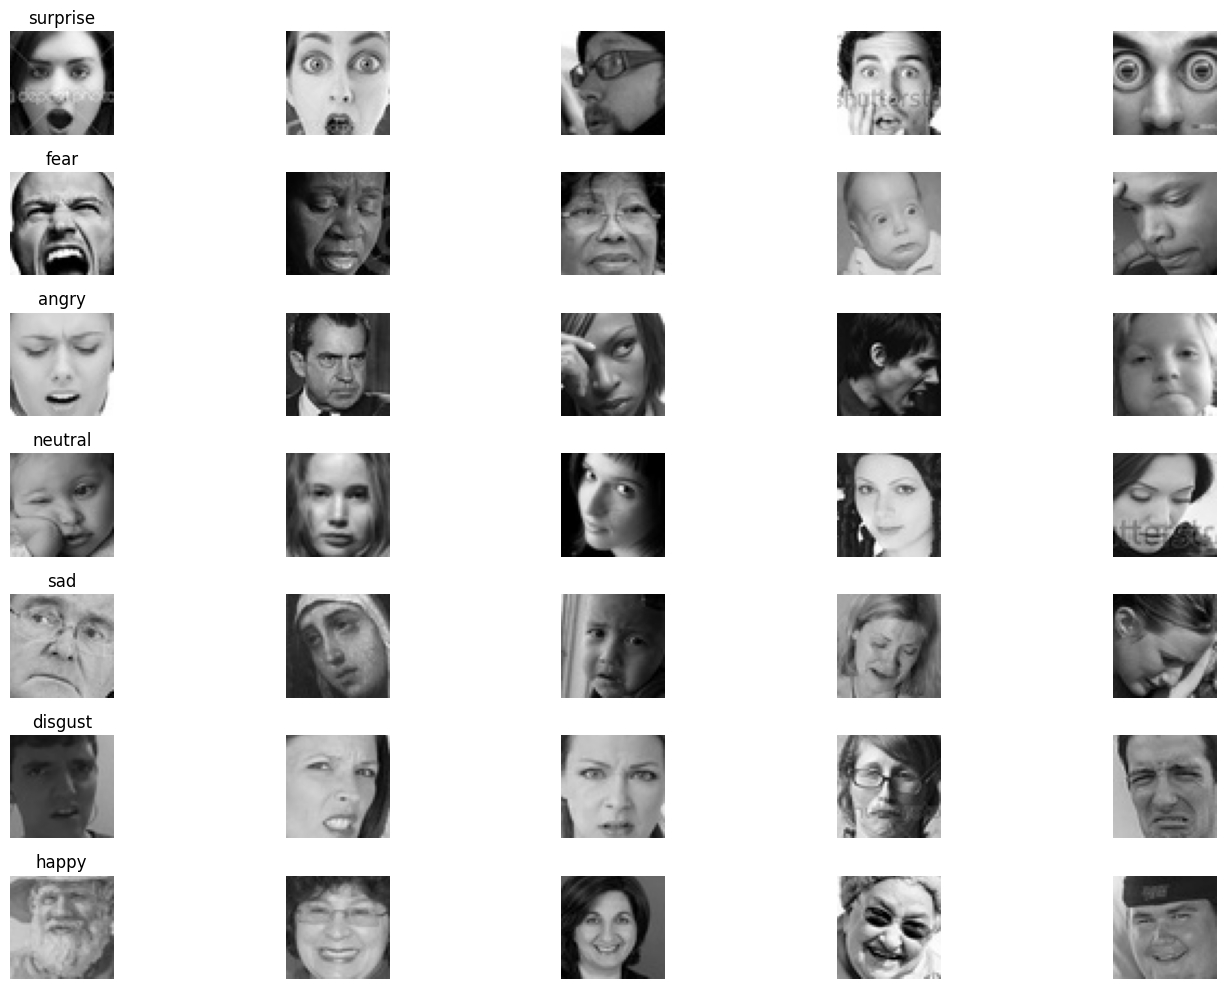

In [45]:
# Set up the directory path for images
data_dir = train_dir
labels = os.listdir(data_dir)  # Each subfolder is a label, e.g., 'angry', 'happy'

# Parameters
target_size = (48, 48)
num_images = 5  # Number of images to display per label
fig, axes = plt.subplots(len(labels), num_images, figsize=(15, 10))

# Loop through each label and image, load, and display
for label_idx, label in enumerate(labels):
    label_dir = os.path.join(data_dir, label)
    images = os.listdir(label_dir)[:num_images]  # Limit to the first `num_images` files

    for img_idx, img_name in enumerate(images):
        img_path = os.path.join(label_dir, img_name)
        
        # Load the image
        img = image.load_img(img_path, target_size=target_size)
        img_array = np.array(img)
        
        # Display the image
        ax = axes[label_idx, img_idx]
        ax.imshow(img_array, cmap='gray')
        ax.axis('off')
        
        # Set label title for the first image in each row
        if img_idx == 0:
            ax.set_title(label, fontsize=12)

plt.tight_layout()
plt.show()

In [35]:
from tensorflow.keras.layers import Input
from tensorflow.keras.optimizers import SGD

def create_vggnet(input_shape=(48, 48, 1), num_classes=7):
    model = Sequential()
    
    # Specify the input shape in an Input layer at the start
    model.add(Input(shape=input_shape))
    
    # Convolutional Block 1
    model.add(Conv2D(64, (3, 3), padding='same', activation='relu'))
    model.add(BatchNormalization())
    model.add(Conv2D(64, (3, 3), padding='same', activation='relu'))
    model.add(BatchNormalization())
    model.add(MaxPooling2D(pool_size=(2, 2)))
    
    # Convolutional Block 2
    model.add(Conv2D(128, (3, 3), padding='same', activation='relu'))
    model.add(BatchNormalization())
    model.add(Conv2D(128, (3, 3), padding='same', activation='relu'))
    model.add(BatchNormalization())
    model.add(MaxPooling2D(pool_size=(2, 2)))
    
    # Convolutional Block 3
    model.add(Conv2D(256, (3, 3), padding='same', activation='relu'))
    model.add(BatchNormalization())
    model.add(Conv2D(256, (3, 3), padding='same', activation='relu'))
    model.add(BatchNormalization())
    model.add(Conv2D(256, (3, 3), padding='same', activation='relu'))
    model.add(BatchNormalization())
    model.add(MaxPooling2D(pool_size=(2, 2)))
    
    # Convolutional Block 4
    model.add(Conv2D(512, (3, 3), padding='same', activation='relu'))
    model.add(BatchNormalization())
    model.add(Conv2D(512, (3, 3), padding='same', activation='relu'))
    model.add(BatchNormalization())
    model.add(Conv2D(512, (3, 3), padding='same', activation='relu'))
    model.add(BatchNormalization())
    model.add(MaxPooling2D(pool_size=(2, 2)))
    
    # Fully Connected Layers
    model.add(Flatten())
    model.add(Dense(4096, activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(4096, activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(num_classes, activation='softmax'))
    
    return model

# Model compilation with SGD and momentum as per the paper's experiment
model = create_vggnet()

model.compile(
    optimizer=SGD(learning_rate=0.001, momentum=0.9),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

# Print the model summary
model.summary()


Model: "sequential_13"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_122 (Conv2D)             │ (None, 48, 48, 64)     │           640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_122         │ (None, 48, 48, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_123 (Conv2D)             │ (None, 48, 48, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_123         │ (None, 48, 48, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_48 (MaxPooling2D) │ (None, 24, 24, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_124 (Conv2D)             │ (None, 24, 24, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_124         │ (None, 24, 24, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_125 (Conv2D)             │ (None, 24, 24, 128)    │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_125         │ (None, 24, 24, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_49 (MaxPooling2D) │ (None, 12, 12, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_126 (Conv2D)             │ (None, 12, 12, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_126         │ (None, 12, 12, 256)    │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_127 (Conv2D)             │ (None, 12, 12, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_127         │ (None, 12, 12, 256)    │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_128 (Conv2D)             │ (None, 12, 12, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_128         │ (None, 12, 12, 256)    │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_50 (MaxPooling2D) │ (None, 6, 6, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_129 (Conv2D)             │ (None, 6, 6, 512)      │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_129         │ (None, 6, 6, 512)      │         2,048 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_130 (Conv2D)             │ (None, 6, 6, 512)      │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_130         │ (None, 6, 6, 512)      │         2,04

 Total params: 43,333,319 (165.30 MB)

 Trainable params: 43,327,943 (165.28 MB)

 Non-trainable params: 5,376 (21.00 KB)

In [36]:
# Use the previously defined custom VGGNet model
model = create_vggnet(input_shape=(48, 48, 1), num_classes=7)

# Compile the model with SGD optimizer and momentum
model.compile(
    optimizer=tf.keras.optimizers.SGD(learning_rate=0.001, momentum=0.9),
    loss='categorical_crossentropy',
    metrics=['accuracy','precision','recall']
)

# Define learning rate scheduler (Reduce LR on Plateau)
reduce_lr = ReduceLROnPlateau(
    monitor='val_accuracy',  # Monitor validation accuracy
    factor=0.75,             # Reduce learning rate by 0.75
    patience=5,              # Wait 5 epochs with no improvement
    min_lr=1e-5,             # Lower limit on learning rate
    verbose=1
)

# Checkpoint to save the best model
checkpoint = ModelCheckpoint(
   'model.weights.h5',   # File to save the model '/kaggle/working/custom_vggnet_weights.h5'
    monitor='val_accuracy',          # Monitor validation accuracy
    save_best_only=True, 
    save_weights_only=True,# Save only the best model
    mode='max',
    verbose=1
)



# Fit the model on the training data with validation
history = model.fit(
    train_generator,
    epochs=100,
    validation_data=validation_generator,
    callbacks=[reduce_lr, checkpoint]
)

Epoch 1/100
717/718 ━━━━━━━━━━━━━━━━━━━━ 0s 134ms/step - accuracy: 0.1986 - loss: 2.4608 - precision: 0.2079 - recall: 0.0823
Epoch 1: val_accuracy improved from -inf to 0.25449, saving model to model.weights.h5
718/718 ━━━━━━━━━━━━━━━━━━━━ 113s 144ms/step - accuracy: 0.1987 - loss: 2.4600 - precision: 0.2080 - recall: 0.0822 - val_accuracy: 0.2545 - val_loss: 1.8034 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - learning_rate: 0.0010
Epoch 2/100
717/718 ━━━━━━━━━━━━━━━━━━━━ 0s 127ms/step - accuracy: 0.2296 - loss: 1.8550 - precision: 0.2919 - recall: 0.0118
Epoch 2: val_accuracy did not improve from 0.25449
718/718 ━━━━━━━━━━━━━━━━━━━━ 97s 134ms/step - accuracy: 0.2296 - loss: 1.8549 - precision: 0.2919 - recall: 0.0118 - val_accuracy: 0.2512 - val_loss: 1.8037 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - learning_rate: 0.0010
Epoch 3/100
717/718 ━━━━━━━━━━━━━━━━━━━━ 0s 128ms/step - accuracy: 0.2446 - loss: 1.8179 - precision: 0.3977 - recall: 0.0067
Epoch 3: val_acc

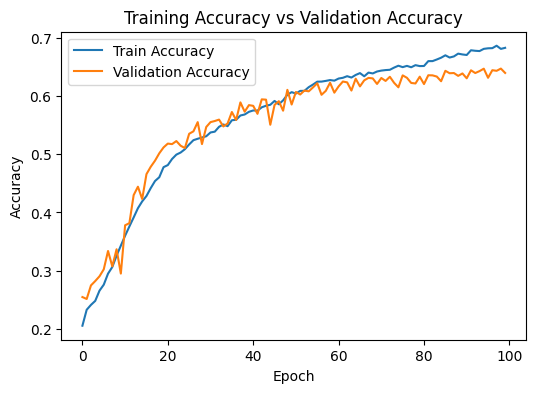

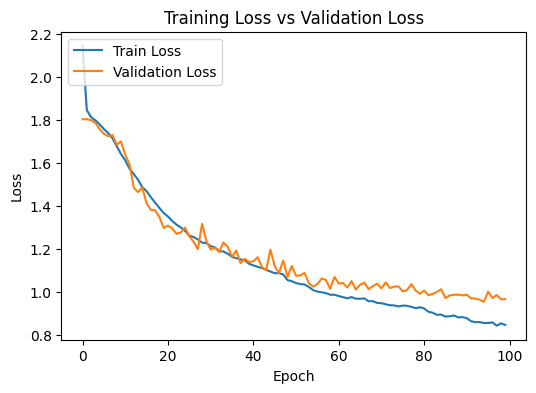

In [37]:
# Plot Training and Validation Accuracy
plt.figure(figsize=(6, 4))
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training Accuracy vs Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(loc='upper left')
plt.show()

# Plot Training and Validation Loss
plt.figure(figsize=(6, 4))
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training Loss vs Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(loc='upper left')
plt.show()

In [43]:

# Predict the labels for the test set
y_pred = model.predict(test_generator)

# Convert the predicted probabilities to class labels (index of max probability)
y_pred_classes = np.argmax(y_pred, axis=1)

# Get the true labels from the test generator (flatten to match the predicted labels shape)
y_true = test_generator.classes  
y_true = np.array(y_true)
# Get the class labels
class_labels = list(test_generator.class_indices.keys())
# Display classification report
print(classification_report(y_true, y_pred_classes ,target_names=class_labels))

225/225 ━━━━━━━━━━━━━━━━━━━━ 8s 34ms/step
              precision    recall  f1-score   support

       angry       0.55      0.61      0.58       958
     disgust       0.61      0.33      0.43       111
        fear       0.54      0.36      0.43      1024
       happy       0.89      0.83      0.86      1774
     neutral       0.54      0.68      0.60      1233
         sad       0.52      0.54      0.53      1247
    surprise       0.75      0.78      0.77       831

    accuracy                           0.64      7178
   macro avg       0.63      0.59      0.60      7178
weighted avg       0.65      0.64      0.64      7178



In [44]:
#model.save('model_optimal.h5')
model.save('/kaggle/working/best_model_custom_vggnet.h5')


In [42]:
import shutil

# Copy the best weights to a persistent location
shutil.copy('model.weights.h5', '/kaggle/working/best_model_weights.h5')


'/kaggle/working/best_model_weights.h5'

225/225 ━━━━━━━━━━━━━━━━━━━━ 7s 32ms/step
              precision    recall  f1-score   support

       angry       0.55      0.61      0.58       958
     disgust       0.61      0.33      0.43       111
        fear       0.54      0.36      0.43      1024
       happy       0.89      0.83      0.86      1774
     neutral       0.54      0.68      0.60      1233
         sad       0.52      0.54      0.53      1247
    surprise       0.75      0.78      0.77       831

    accuracy                           0.64      7178
   macro avg       0.63      0.59      0.60      7178
weighted avg       0.65      0.64      0.64      7178

Confusion Matrix:
 [[ 584    9   77   24  119  124   21]
 [  54   37    4    2    4    8    2]
 [ 138    9  372   24  140  234  107]
 [  47    2   31 1465  154   42   33]
 [  69    1   33   54  834  214   28]
 [ 140    2  102   36  270  675   22]
 [  29    1   76   40   25   11  649]]


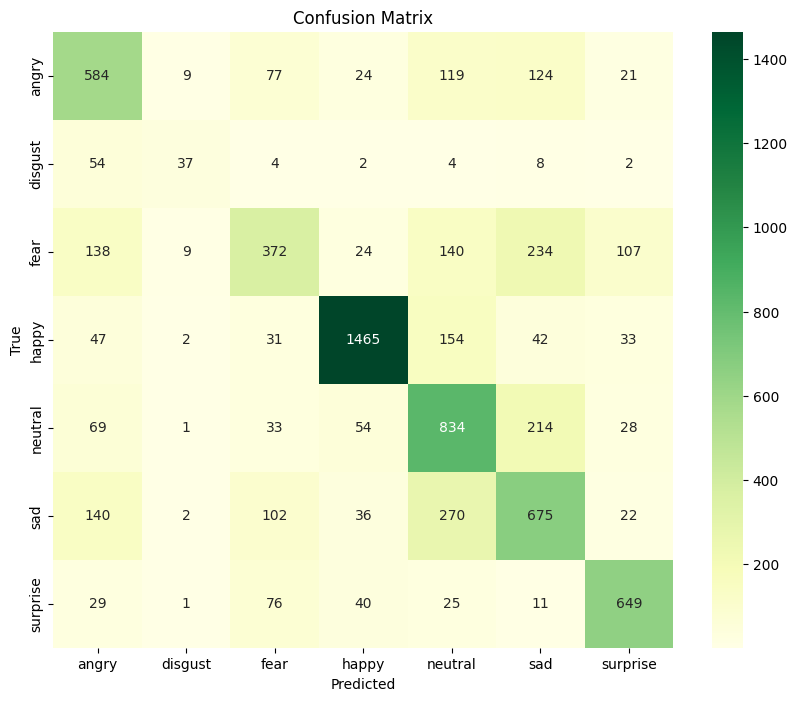

In [41]:
import numpy as np
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Get true labels from the test dataset
y_true = test_generator.classes
y_pred_probs = model.predict(test_generator)
y_pred = np.argmax(y_pred_probs, axis=1)  # Convert probabilities to class labels

# Generate classification report
print(classification_report(y_true, y_pred, target_names=test_generator.class_indices.keys()))

# Compute confusion matrix
conf_matrix = confusion_matrix(y_true, y_pred)
print("Confusion Matrix:\n", conf_matrix)



plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='YlGn', 
            xticklabels=test_generator.class_indices.keys(),
            yticklabels=test_generator.class_indices.keys())
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()